In [3]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf


# **Data Reading and Understanding**

In [4]:
batch_size = 32
img_height = 224
img_width = 224
data_dir = "/kaggle/input/teethdata/Teeth_Dataset"

In [6]:
# Load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + "/Training",
    labels="inferred",
    label_mode="int",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
)

Found 3087 files belonging to 7 classes.


In [7]:
# Load validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + "/Validation",
    labels="inferred",
    label_mode="int",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False,
)



Found 1028 files belonging to 7 classes.


In [8]:
# Load test dataset (optional)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + "/Testing",
    labels="inferred",
    label_mode="int",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False,
)

Found 1028 files belonging to 7 classes.


In [9]:
class_names = train_ds.class_names
print("Class names:", class_names)

Class names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


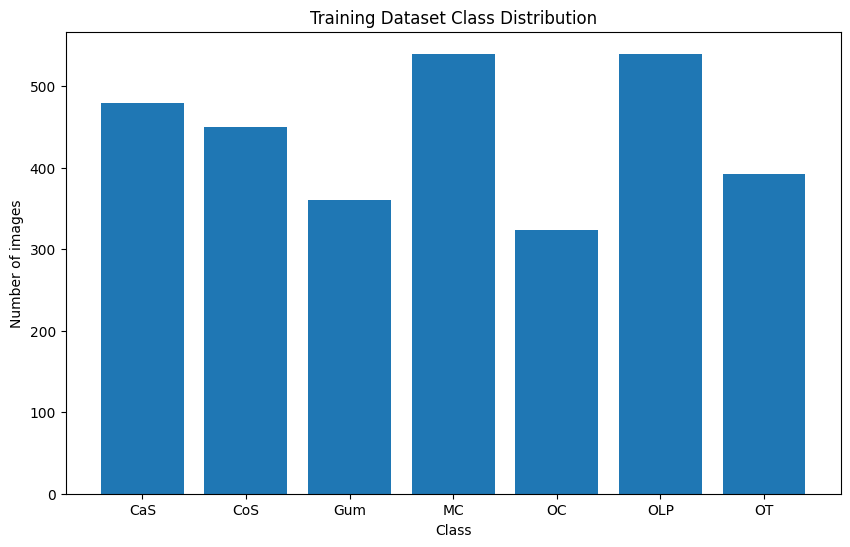

In [10]:
#Data distribution 

import matplotlib.pyplot as plt

# Count samples per class
class_counts = {class_name: 0 for class_name in class_names}
for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[class_names[label]] += 1

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Training Dataset Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()


In [11]:
import numpy as np
from collections import Counter

# Collect all labels from the dataset
all_labels = []

for _, labels in train_ds.unbatch():
    all_labels.append(labels.numpy())

# Count each class
label_counts = Counter(all_labels)

# Map integer labels back to class names
for label_idx, count in sorted(label_counts.items()):
    class_name = class_names[label_idx]
    print(f"{class_name}: {count} images")


CaS: 480 images
CoS: 450 images
Gum: 360 images
MC: 540 images
OC: 324 images
OLP: 540 images
OT: 393 images


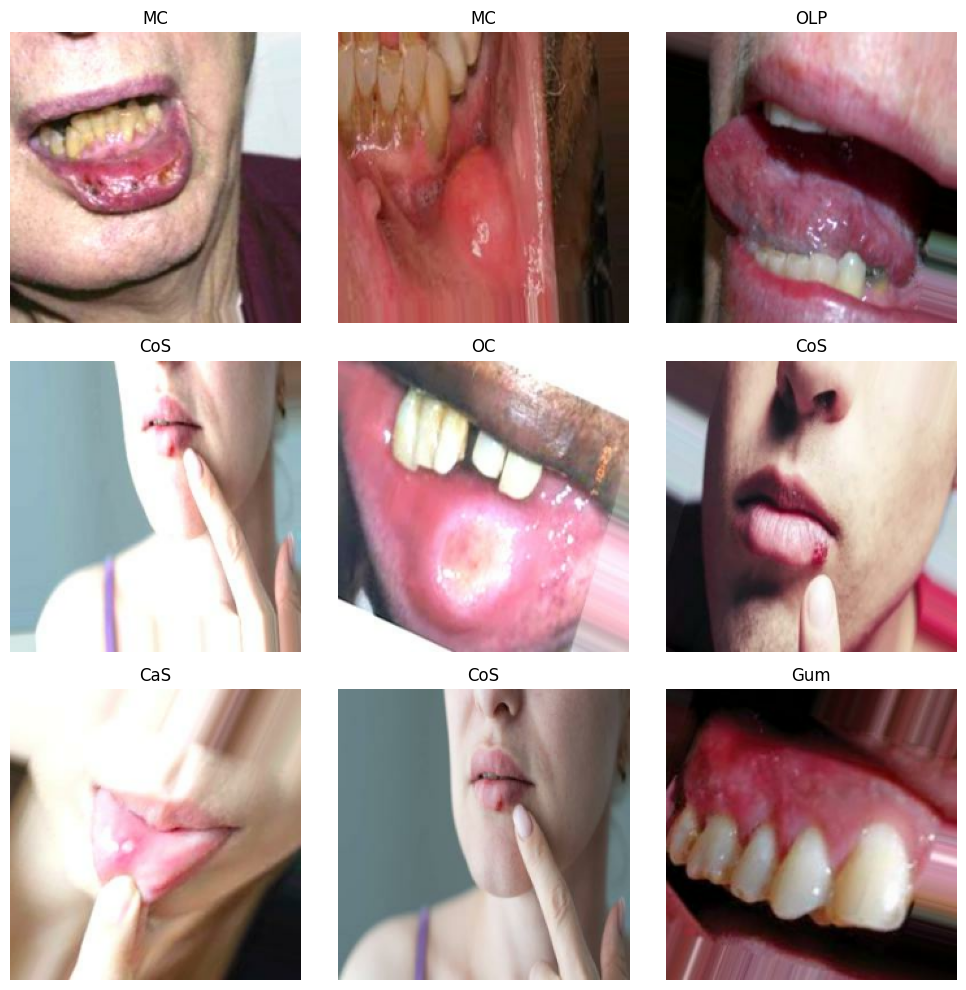

In [12]:
import matplotlib.pyplot as plt

# Display 9 sample images from the training set
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):  # Take one batch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.tight_layout()
plt.show()


# **Preprocessing & Visualization**

Resize & Normalize

In [13]:
from tensorflow.keras import layers

# Resize and normalize layer
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1./255)
])


In [14]:
val_preprocessing = tf.keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1./255),
])

In [15]:
for images, labels in train_ds.take(1):
    original_img = images[0].numpy()
    resized_normalized_img = resize_and_rescale(images[0]).numpy()

    print("Original pixel range:", original_img.min(), "-", original_img.max())
    print("After normalization:", resized_normalized_img.min(), "-", resized_normalized_img.max())
    break

print("Original shape:", images[0].shape)
print("After resize:", resize_and_rescale(images[0]).shape)


Original pixel range: 0.21429062 - 255.0
After normalization: 0.0008403554 - 1.0
Original shape: (224, 224, 3)
After resize: (224, 224, 3)


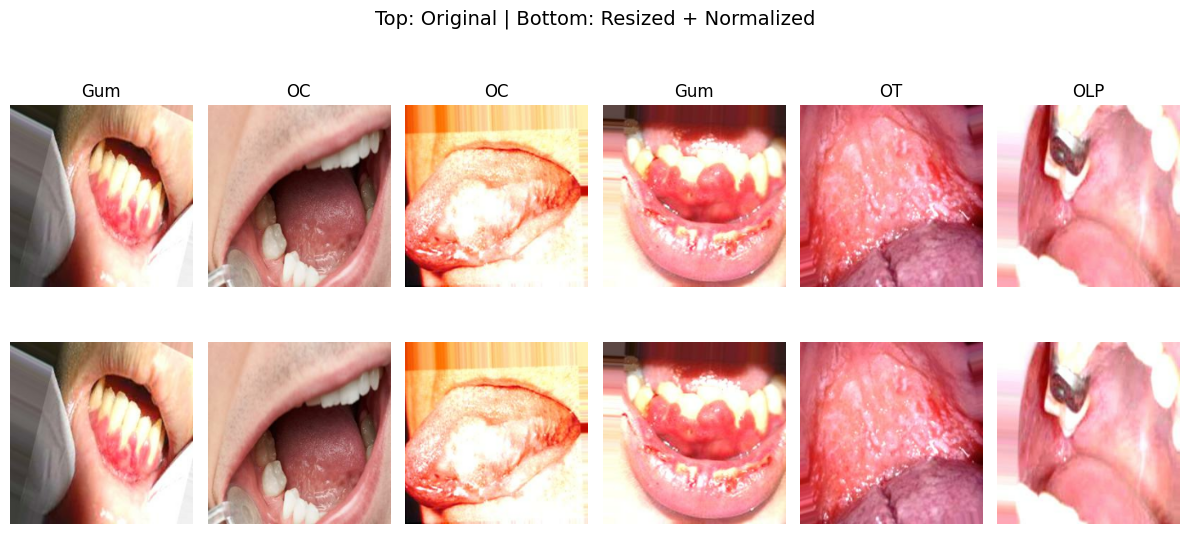

In [16]:
# Take 1 batch from training
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(6):
        # Original
        ax = plt.subplot(2, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

        # After resize & normalize
        ax = plt.subplot(2, 6, i + 7)
        img_rescaled = resize_and_rescale(images[i])
        plt.imshow(img_rescaled.numpy())
        plt.axis("off")

    plt.suptitle("Top: Original | Bottom: Resized + Normalized", fontsize=14)
    plt.tight_layout()
    plt.show()
    break


Data Augmentation

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [18]:
#Combine Resize + Normalize + Augmentation
train_preprocessing = tf.keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1./255),
    data_augmentation
])


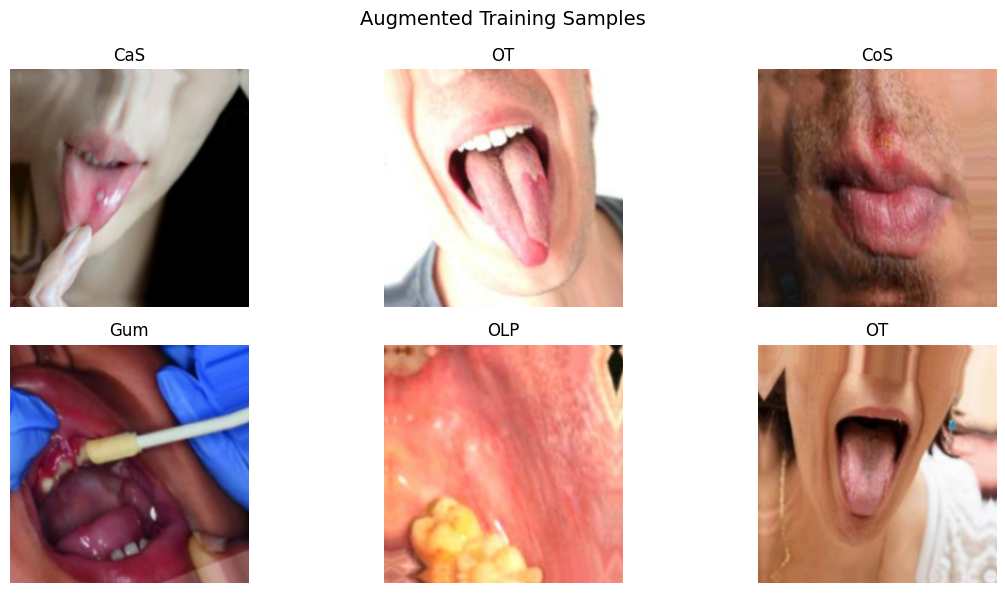

In [19]:
import matplotlib.pyplot as plt

# Take 1 batch from train_ds
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        augmented_image = train_preprocessing(images[i])
        plt.imshow(augmented_image.numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")

    plt.suptitle("Augmented Training Samples", fontsize=14)
    plt.tight_layout()
    plt.show()
    break


In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# **Modeling**

**EfficientNetB0 Architicture**

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0


In [22]:
base_model = EfficientNetB0(input_shape=(224, 224, 3),
                            include_top=False,
                            weights='imagenet')

base_model.trainable = False  # freeze pretrained weights initially

inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # keep base_model in inference mode during training
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)  # prevent overfitting
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [23]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │           8,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

**Training**

In [24]:
initial_epochs = 20

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=initial_epochs)


Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.3726 - loss: 1.6497 - val_accuracy: 0.6167 - val_loss: 1.0330
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.6654 - loss: 0.9671 - val_accuracy: 0.7344 - val_loss: 0.8184
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.7195 - loss: 0.8332 - val_accuracy: 0.7685 - val_loss: 0.7053
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.7633 - loss: 0.7141 - val_accuracy: 0.8045 - val_loss: 0.6228
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.8176 - loss: 0.6093 - val_accuracy: 0.8346 - val_loss: 0.5639
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.8310 - loss: 0.5520 - val_accuracy: 0.8424 - val_loss: 0.5212
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.8483 - loss: 0.5230 - val_accuracy: 0.8648 - val_loss: 0.4756
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.8546 - loss: 0.4820 - val_accuracy: 0.8638 - v

**Fine Tuning**

In [25]:
# Unfreeze the base model
base_model.trainable = True

# Optional: Freeze first layers, fine-tune last layers only
fine_tune_at = 100  # example layer index
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate for fine-tuning
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_epochs = 40
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1])


Epoch 20/60
97/97 ━━━━━━━━━━━━━━━━━━━━ 310s 3s/step - accuracy: 0.4225 - loss: 1.7426 - val_accuracy: 0.8259 - val_loss: 0.4889
Epoch 21/60
97/97 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - accuracy: 0.5722 - loss: 1.1999 - val_accuracy: 0.7665 - val_loss: 0.6359
Epoch 22/60
97/97 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - accuracy: 0.6580 - loss: 0.9525 - val_accuracy: 0.7802 - val_loss: 0.6172
Epoch 23/60
97/97 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - accuracy: 0.7353 - loss: 0.7539 - val_accuracy: 0.7996 - val_loss: 0.5568
Epoch 24/60
97/97 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.7827 - loss: 0.6373 - val_accuracy: 0.8307 - val_loss: 0.4927
Epoch 25/60
97/97 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.8226 - loss: 0.5313 - val_accuracy: 0.8521 - val_loss: 0.4362
Epoch 26/60
97/97 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.8538 - loss: 0.4640 - val_accuracy: 0.8765 - val_loss: 0.3861
Epoch 27/60
97/97 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - accuracy: 0.8663 - loss: 0.4287 - val_accuracy: 0.

**Evaluation**

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

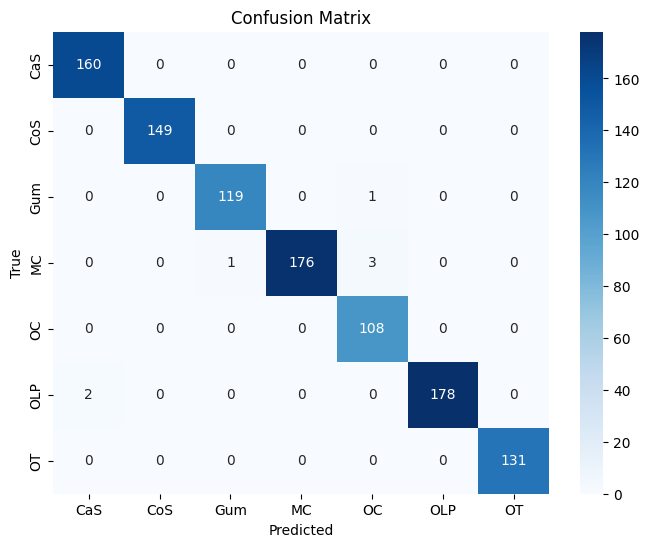

In [26]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Get all predictions and true labels
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

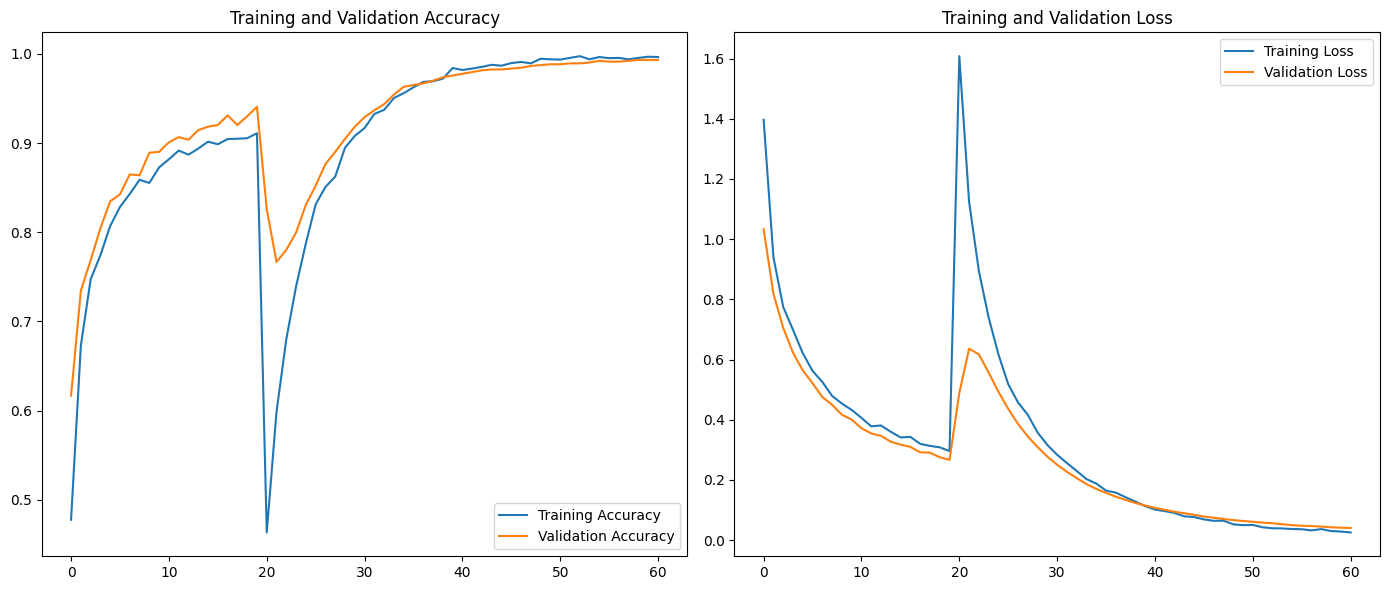

In [27]:
import matplotlib.pyplot as plt

# Combine both history phases
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs_range = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


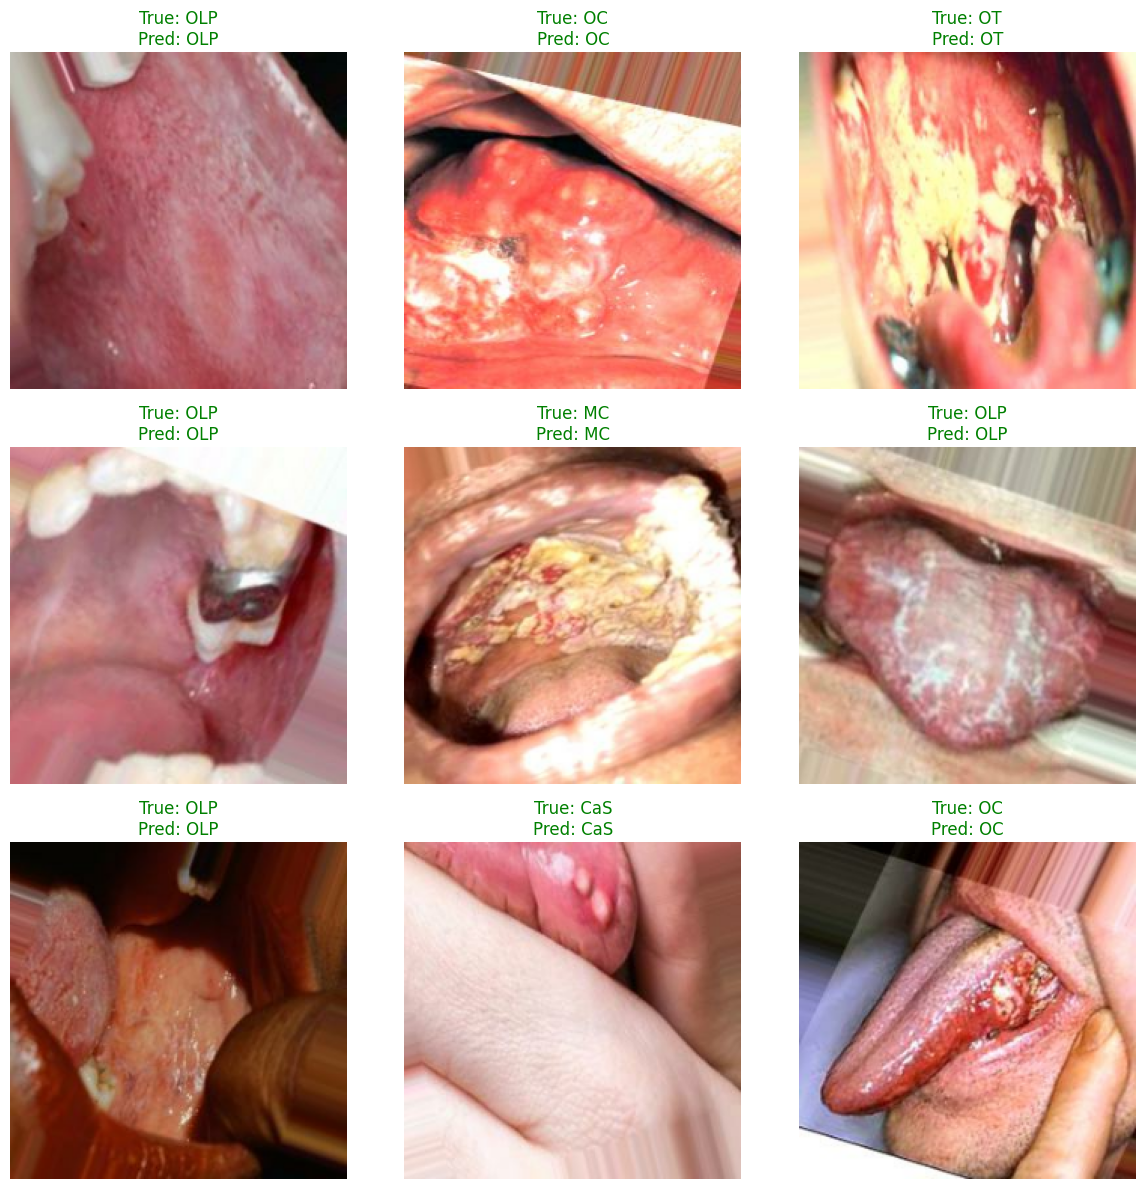

In [35]:
import matplotlib.pyplot as plt
import numpy as np


# Take one batch from training set
for images, labels in train_ds.take(1):
    # Predict
    preds = model.predict(images)
    pred_labels = tf.argmax(preds, axis=1)

    # Plot 9 images with predictions
    plt.figure(figsize=(12, 12))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i]]
        predicted_label = class_names[pred_labels[i]]
        color = "green" if predicted_label == true_label else "red"
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


**Save The Model**

In [28]:
model.save('teeth_EffNet_model.h5')

**Evaluate The Model ON Test Data**

In [29]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9953 - loss: 0.0274
Test Accuracy: 98.93%
Test Loss: 0.0406


In [30]:
import numpy as np

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

         CaS       0.99      1.00      0.99       160
         CoS       1.00      1.00      1.00       149
         Gum       1.00      0.99      1.00       120
          MC       0.97      0.99      0.98       180
          OC       0.97      0.96      0.97       108
         OLP       1.00      0.97      0.99       180
          OT       0.99      1.00      1.00       131

    accuracy                           0.99      1028
   macro avg       0.99      0.99      0.99      1028
weighted avg       0.99      0.99      0.99      1028



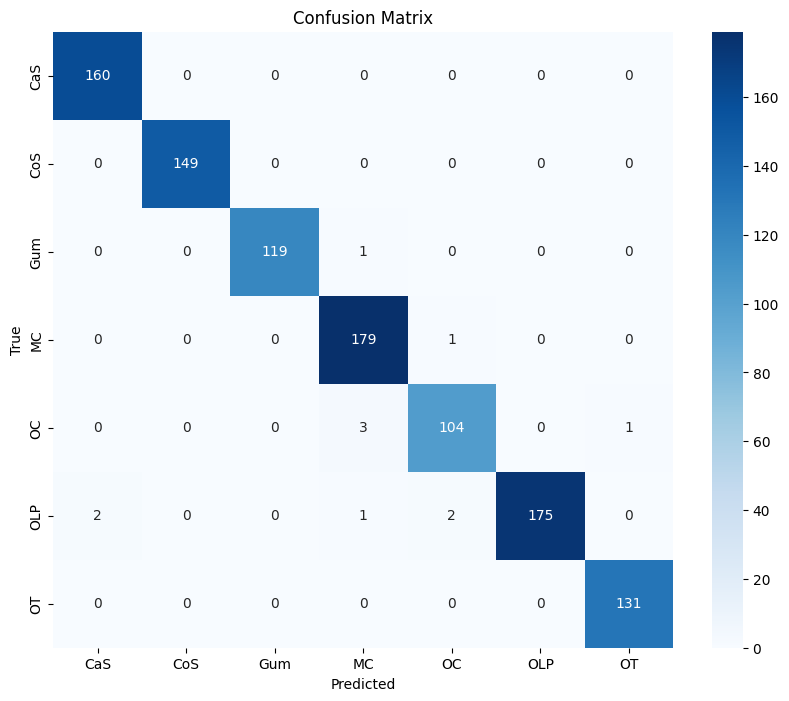

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


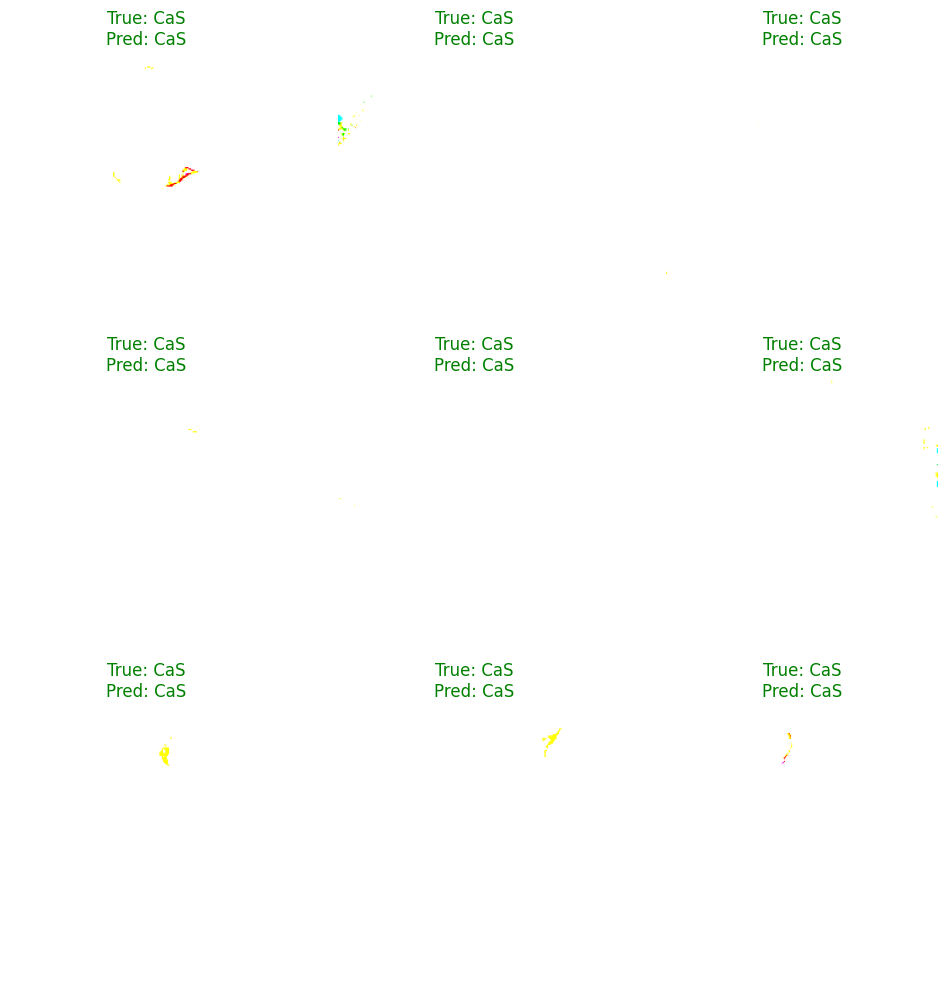

In [33]:
import matplotlib.pyplot as plt

# Show 9 random predictions
plt.figure(figsize=(12, 12))
for images, labels in test_ds.take(1):  # Take 1 batch
    preds = model.predict(images)
    predicted_labels = tf.argmax(preds, axis=1)

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        true_label = class_names[labels[i]]
        pred_label = class_names[predicted_labels[i]]
        color = "green" if true_label == pred_label else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis("off")
